# Time Series Classification in sktime

In this notebook, we will demonstrate a quick run through of `sktime` for time series classification (TSC).

TSC problems have a single (univariate) or multiple (multivariate) time series variable(s) and an associated label for multiple instances.

The goal of a classifier is to learn the relationship between time series and label and accurately predict the label of new series.

We will cover loading datasets and the data formats used by `sktime` classifiers, using `sktime` classifiers for training models and making predictions and using our experiments pipeline to output results in our format.

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sktime.classification.dictionary_based import TemporalDictionaryEnsemble
from sktime.classification.distance_based import ProximityForest
from sktime.classification.interval_based import TimeSeriesForestClassifier, \
    RandomIntervalSpectralForest
from sktime.classification.shapelet_based import ROCKETClassifier, \
    ShapeletTransformClassifier
from sktime.contrib.experiments import run_experiment
from sktime.datasets import load_italy_power_demand, load_basic_motions, \
    load_UCR_UEA_dataset
from sktime.transformations.panel.rocket import Rocket
from sktime.utils.data_io import load_from_tsfile_to_dataframe as load_ts
from sktime.utils.data_processing import from_nested_to_3d_numpy

### Loading datasets

There are 3 primary methods for loading time series datasets in `sktime`.
More details are available in the loading data notebook `loading_data.ipynb` in the main sktime project.

The first and most generally useful of the methods for development loads data directly from http://www.timeseriesclassification.com/, which store the UCR/UEA TSC archive of datasets.

In [3]:
X, y = load_UCR_UEA_dataset("GunPoint", return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

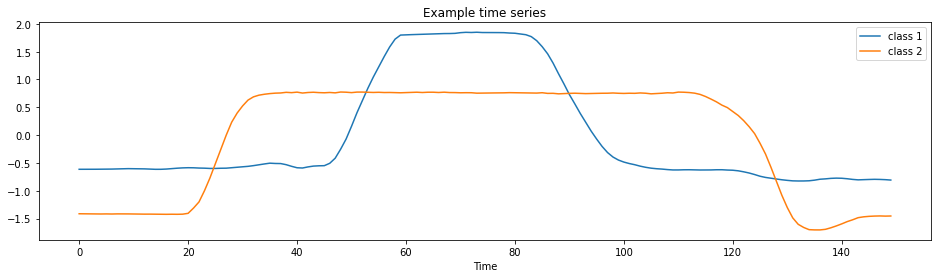

In [4]:
labels, counts = np.unique(y_train, return_counts=True)
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time");

Datasets can be loaded directly from file.
The primary format used for dataset files in `sktime` is `.ts`.
Use these for datasets which are not part of the UCR/UEA archive or you are comparing to someone elses results and need specific train and test splits.

In [20]:
# load_from_tsfile_to_dataframe
X_train, y_train = load_ts("ArrowHead/ArrowHead_TRAIN.ts")
X_test, y_test = load_ts("ArrowHead/ArrowHead_TEST.ts")

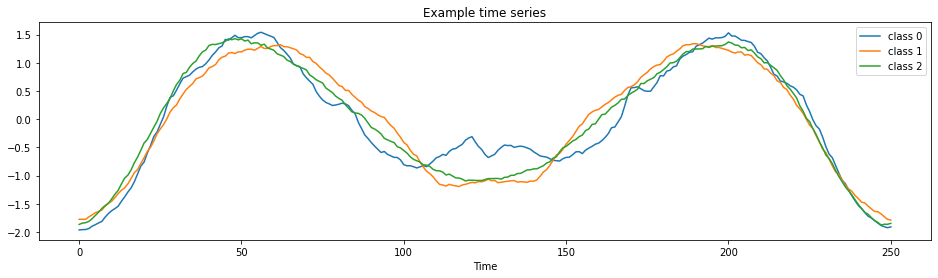

In [6]:
labels, counts = np.unique(y_train, return_counts=True)
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time");

Lastly some of the smaller datasets are stored as part of the `sktime` package.
These datasets can be loaded using specific functions and are important for unit testing.

In [21]:
X, y = load_italy_power_demand(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

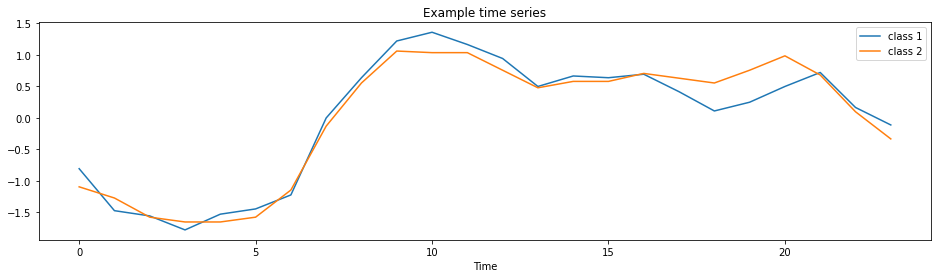

In [8]:
labels, counts = np.unique(y_train, return_counts=True)
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time");

### Data formats

By default the above methods load the data into nested pandas dataframe:

In [9]:
X_train.head()

,dim_0
535,0 -1.097900 1 -1.275600 2 -1.580200 3...
27,0 -0.648470 1 -1.094700 2 -1.373600 3...
779,0 -0.78939 1 -1.29000 2 -1.44810 3 ...
762,0 -0.809670 1 -1.476900 2 -1.560300 3...
276,0 -0.674510 1 -1.146300 2 -1.382200 3...


In [10]:
y.head()

0    1
1    1
2    2
3    2
4    1
dtype: object

Another acceptable format, and one which a lot of classifiers transform the input data into is 3d numpy arrays:

In [11]:
from_nested_to_3d_numpy(X)[:5]

array([[[-0.71052 , -1.1833  , -1.3724  , -1.5931  , -1.467   ,
         -1.3724  , -1.0888  ,  0.045967,  0.92853 ,  1.0861  ,
          1.2753  ,  0.96005 ,  0.61333 ,  0.014447, -0.64748 ,
         -0.26923 , -0.20619 ,  0.61333 ,  1.3698  ,  1.4644  ,
          1.0546  ,  0.58181 ,  0.17205 , -0.26923 ]],

       [[-0.99301 , -1.4268  , -1.5799  , -1.6054  , -1.6309  ,
         -1.3758  , -1.0185  , -0.3551  ,  0.71658 ,  1.2014  ,
          1.1248  ,  1.0483  ,  0.79313 ,  0.46142 ,  0.48694 ,
          0.56348 ,  0.61452 ,  0.30832 ,  0.25729 ,  1.0993  ,
          1.0483  ,  0.69107 , -0.048906, -0.38062 ]],

       [[ 1.3191  ,  0.56977 ,  0.19513 , -0.085856, -0.17952 ,
         -0.27318 , -0.085856, -1.3971  , -1.1161  , -0.74149 ,
          0.007805, -0.085856,  0.007805, -0.4605  , -0.55416 ,
         -0.74149 , -0.74149 , -0.74149 , -1.1161  , -0.4605  ,
          0.47611 ,  2.3493  ,  2.2557  ,  1.6001  ]],

       [[-0.81244 , -1.1576  , -1.4164  , -1.5314  , -1.5027  ,


In [12]:
y.to_numpy()[:5]

array(['1', '1', '2', '2', '1'], dtype=object)

### Running sktime classifiers

Running sktime classifiers is very similar to sklearn.
For both univariate and multivariate data the same process is followed.

- Define a classifier
- Fit the classifier using train data and labels
- Classify new data using predict/predict_proba/score

#### Univariate classifiers

In [13]:
tsf = TimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.9781021897810219

#### Multivariate classifiers

In [14]:
X_mv, y_mv = load_basic_motions(return_X_y=True)
X_train_mv, X_test_mv, y_train_mv, y_test_mv = train_test_split(X_mv, y_mv)

rocket = ROCKETClassifier()
rocket.fit(X_train_mv, y_train_mv)
rocket.score(X_test_mv, y_test_mv)

1.0

#### Pipeline classifiers

We typically focus on implementing and using specific TSC algorithms.
Pipelines are another way of forming classifiers, however.
The below pipeline is functionally the same as the ROCKETClassifier above.

In [15]:
rocket_pipeline = make_pipeline(
    Rocket(),
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
)
rocket_pipeline.fit(X_train_mv, y_train_mv)
rocket_pipeline.score(X_test_mv, y_test_mv)

1.0

### Configuring Classifiers

Each classifier will have its own hyper-parameters, most commonly the number of estimators for ensembles.
A few will be shared between all, however. Options we want available for most classifiers in `sktime` are:

- n_jobs: The number of threads the classifier should aim to utilise
- contracting: A time limit for train time which the classifier will aim to meet

In [16]:
# Parallelised but no contracting
rise = RandomIntervalSpectralForest(n_estimators=100, n_jobs=4)

# Has contracting and parallelisation through the SFA transform, in a good state.
tde = TemporalDictionaryEnsemble(max_ensemble_size=25, time_limit=5, n_jobs=4)

# Basic parallelisation through numba, but no contracting
rocket = ROCKETClassifier(num_kernels=2000, n_jobs=4)

# Parallelised but no contracting
pf = ProximityForest(n_estimators=100, n_jobs=4)

# Has contracting for the transform half of the classifier, not parallelised
stc = ShapeletTransformClassifier(time_contract_in_mins=5)

### Experiments

The experiments file if what we use to generate results for classifier/dataset combinations.
run_experiment will build a classifier on a dataset from a specified location and output a results file in our format.

In [22]:
run_experiment(
    overwrite=True,
    problem_path="./",
    results_path="./",
    cls_name="ROCKET",
    dataset="ArrowHead",
    resampleID=0,
)

ROCKET on ArrowHead resample number 0
ROCKET on ArrowHead resample number 0 test acc: 0.8171428571428572 time: 668
{'ensemble': None, 'ensemble_size': 25, 'n_estimators': None, 'n_jobs': 1, 'num_kernels': 10000, 'random_state': 0}
